In [1]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.misc.productivity import faculty_at_institution
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from scipy.special import gamma as gammaf
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.cross_validation import StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from collections import Counter, defaultdict
from scipy import interp
import statsmodels.api as sm
import numpy as np
import math
import scipy as sp
import pandas as pd
import os
import mpld3
import palettable
import pickle

sig_level = 0.05

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/figures/'
#nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst)
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']

load.load_all_publications(asst_faculty, dblp_dir)

In [3]:
valid_titles = ['Assistant Professor', 'Associate Professor', 'Full Professor']

In [4]:
followup_data = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/Finalized_Spreadsheet_Nov21.tsv'

def load_followup_data(faculty, followup_file):
    """ Loads the follow-up spreadsheet data collected by BuffTurkers in Nov2016 """
    df = pd.read_csv(followup_file, sep='\t')
    profiles_updated = 0
    
    for person in faculty:
        # When collection assignements are created, these fields are written out:
        # person.facultyName, person.place, person.current
        num_records = len(df[df['Faculty name'] == person.facultyName])
        if num_records == 0: # No matches, this is fine
            continue  
        elif num_records == 1: # One match, this is great
            row = df[df['Faculty name'] == person.facultyName]
            if row['Institution (2011)'].iloc[0] != person.place:
                continue
            person['followup_title'] = row['Job Title (2016)'].iloc[0]
            person['followup_location'] = row['Institution (2016)'].iloc[0]
            person['followup_department'] = row['Department (2016)'].iloc[0]
            profiles_updated += 1
        else: # Multiple matches, this... is bad. Blow up.
            raise ValueError('Multiple records detected!')
            
    assert (profiles_updated <= len(df))
    print 'Updated %d profiles!' % (profiles_updated)

load_followup_data(asst_faculty, followup_data)

Updated 555 profiles!


## Compare with Publications

In [5]:
trajectories_position = Counter()
trajectories_location = Counter()
trajectories_moved_and_left = Counter()
for person in asst_faculty:
    if 'followup_title' in person and 'current' in person:
        key = "%s -> %s" % (person['current'], person['followup_title'])
        trajectories_position[key] += 1
        
        key = "%s" % ("STAYED" if person['followup_location'] == person['place'] else "MOVED")
        trajectories_location[key] += 1
        
        if person['followup_location'] != person['place']:
            key = "%s" % ("LEFT ACADEMIA" if person['followup_location'] == "NOT IN ACADEMIA" else "STAYED IN ACADEMIA")
            trajectories_moved_and_left[key] += 1
        
print trajectories_position
print trajectories_location
print trajectories_moved_and_left

Counter({'Assistant Professor -> Associate Professor': 366, 'Assistant Professor -> Assistant Professor': 104, 'Assistant Professor -> NOT TT': 68, 'Assistant Professor -> Full Professor': 17})
Counter({'STAYED': 404, 'MOVED': 151})
Counter({'STAYED IN ACADEMIA': 78, 'LEFT ACADEMIA': 73})


## Compare with median

In [6]:
# Load OLS fit from Figure 1
lm = pickle.load(open('linear_regression.p', 'rb'))
df = pickle.load(open('real_data.p', 'rb'))
#lm.summary()
pubs_by_year_by_inst = pickle.load(open('pubs_by_inst.p', 'rb'))

In [7]:
lm.params

Intercept    4.432887
prestige    -0.015082
dtype: float64

In [8]:
std = {}
for index, row in df.iterrows():
    std[row['prestige']] = math.sqrt((row['pubs'] - (lm.params.prestige*(row['prestige']) + lm.params.Intercept))**2)

                            OLS Regression Results                            
Dep. Variable:                   pubs   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.591
Date:                Mon, 19 Dec 2016   Prob (F-statistic):             0.0334
Time:                        22:16:07   Log-Likelihood:                -224.67
No. Observations:                 203   AIC:                             453.3
Df Residuals:                     201   BIC:                             460.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.1098      0.113      9.807      0.0

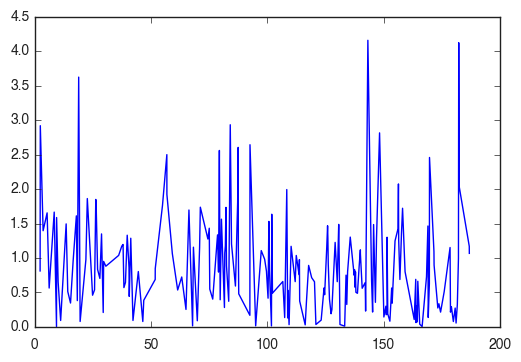

In [9]:
fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
x = sorted(std.keys())
y = [std[key] for key in x]

vects = []
for i, _ in enumerate(x):
    vect = np.zeros(2, dtype=float)
    vect[0] = y[i]
    vect[1] = x[i]
    vects.append(vect)

df_prime = pd.DataFrame(np.array(vects), columns=["pubs", "prestige"])
lm_prime = smf.ols(formula='pubs ~ prestige ', data=df_prime).fit()
print(lm_prime.summary())

print "Line of best fit has a slope of %.4f" % (lm_prime.params.prestige)
    
plt.plot(x, y)
plt.show()

In [26]:
# Compare the average publication rate of a person in their first five years, 
# to the average publication rate of faculty within their first five years at
# both the institution they came from and went to
publication_trajectories = []
data = []
count = 0; count_below = 0;
for person in asst_faculty:
    if 'followup_title' in person and person.__contains__('dblp_pubs'):
        initial_institution = person.place
        final_institution = person['followup_location']
        
        if initial_institution == final_institution:
            # Don't consider those people who took promotions at the same institution.
            continue
        # This will skip anyone who left academia (i.e. their final_institution == "NOT TT")
        if pubs_by_year_by_inst.has_key(initial_institution):
            # Get this person's publication rate
            start = person.first_asst_job_year
            end = np.min([2012, start + 5])
            career_length = end - start
        
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            
            personal_pub_rate = (contribution/float(career_length))
            
            initial_rank = inst[initial_institution]['pi']
            initial_med = lm.params.prestige*(initial_rank) + lm.params.Intercept
            z_initial = float(personal_pub_rate - initial_med)
            
            if final_institution == "NOT IN ACADEMIA":
                count += 1
                if z_initial < 0:
                    count_below += 1
                    #print(personal_pub_rate, initial_rank, z_initial)
            
            if pubs_by_year_by_inst.has_key(final_institution):
                final_rank = inst[final_institution]['pi']
                final_med = lm.params.prestige*(final_rank) + lm.params.Intercept
                z_final = float(personal_pub_rate - final_med)
                
                publication_trajectories.append((
                    initial_rank, 
                    final_rank, 
                    z_initial,
                    z_final
                ))
                data.append([personal_pub_rate, initial_rank, initial_med, final_rank, final_med])

In [30]:
count_below/count

0.6301369863013698

In [108]:
# Write this data out to CSV
#import csv
#with open('tenure_follow_up_2.csv', 'w') as csvfile:
#    fieldnames = ['personal_pub_rate', 'initial_rank', 'initial_med', 'final_rank', 'final_med']
#    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#
#    writer.writeheader()
#    for row in data:
#        writer.writerow({'personal_pub_rate': row[0], 
#                         'initial_rank': row[1],
#                         'initial_med': row[2],
#                         'final_rank': row[3],
#                         'final_med': row[4]
#                        })
#

In [17]:
sim_to_final = 0; sim_to_initial = 0;
for trajectory in publication_trajectories:
    rank_initial = trajectory[0]
    rank_final = trajectory[1]
    
    # Don't consider those who moved down ('>') or moved up ('<')
    if rank_final < rank_initial:
        continue
    
    diff_initial = abs(trajectory[2])
    diff_final = abs(trajectory[3])
    if diff_final < diff_initial:
        sim_to_final += 1
    elif diff_final > diff_initial:
        sim_to_initial += 1
    elif diff_initial == diff_final:
        print "I don't think this happens!"

In [18]:
print(sim_to_final+sim_to_initial)

29


In [20]:
print(sim_to_initial/(sim_to_final+sim_to_initial))
print(sim_to_initial)

0.551724137931
16


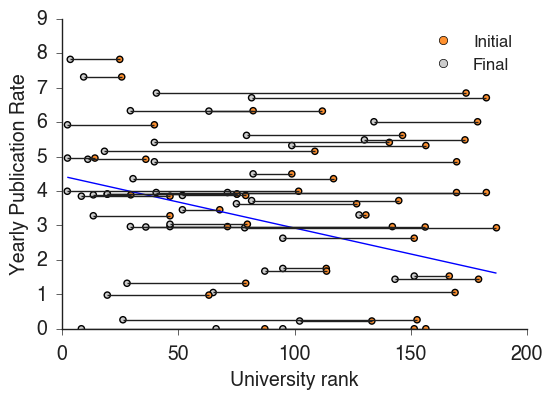

In [164]:
fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
x = sorted(std.keys())
y = [(lm.params.prestige*x_i + lm.params.Intercept) for x_i in x]
plt.plot(x, y)
for i, trajectory in enumerate(publication_trajectories):
    personal_pub_rate = data[i][0]
    rank_initial = trajectory[0]
    rank_final = trajectory[1]
    
    # Don't consider those who moved down
    if rank_final > rank_initial:
        continue
    
    plt.plot([rank_initial, rank_final], [personal_pub_rate, personal_pub_rate], color=ALMOST_BLACK)
    ax.scatter([rank_initial, rank_final], [personal_pub_rate, personal_pub_rate], c=[ACCENT_COLOR_1, LIGHT_COLOR])
    
fake_line_initial = Line2D(range(0), range(0), color=ACCENT_COLOR_1, marker='o', alpha = 1.0, linestyle='None')
fake_line_final = Line2D(range(0), range(0), color=LIGHT_COLOR, marker='o', alpha = 1.0, linestyle='None')
    
plt.legend(
        (
            fake_line_initial,
            fake_line_final
        ),(
            "Initial",
            "Final"
        ), numpoints=1, loc='upper right', frameon=False, fontsize=LEGEND_SIZE, ncol=1)
    
ax.set_ylabel("Yearly Publication Rate")
ax.set_xlabel("University rank")

ax.set_xlim(0,200)
ax.set_ylim(0,9)

finalize(ax)
plt.show()

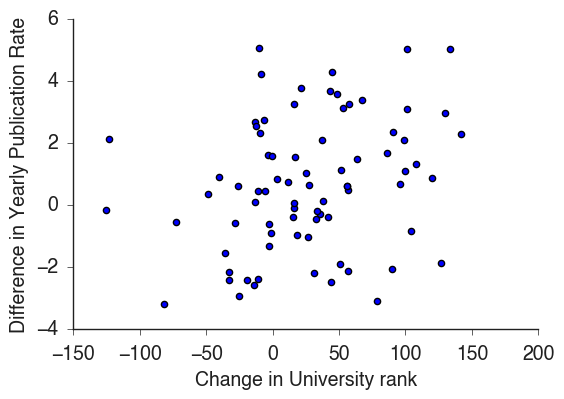

In [168]:
fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
y = {}
for pi in std.keys():
    y[pi] = lm.params.prestige*pi + lm.params.Intercept

delta_ranks = []; delta_y = [];
for i, trajectory in enumerate(publication_trajectories):
    personal_pub_rate = data[i][0]
    rank_initial = trajectory[0]
    rank_final = trajectory[1]
    
    delta_ranks.append(rank_initial-rank_final)
    delta_y.append(personal_pub_rate-y[rank_initial])
    
    
ax.scatter(delta_ranks, delta_y)
    
ax.set_ylabel("Difference in Yearly Publication Rate")
ax.set_xlabel("Change in University rank")

finalize(ax)
plt.show()

## Compare with lognormals

In [171]:
# Compare the average publication rate of a person in their first five years
# to the average publication rate of faculty within their first five years at
# both the institution they came from and went to
publication_trajectories = []
for person in asst_faculty:
    if 'followup_title' in person and person.__contains__('dblp_pubs'):
        initial_institution = person.place
        final_institution = person['followup_location']
        # Get average publication rate of the young faculty at either institution
        if initial_institution == final_institution:
            # Don't consider those people who took promotions at the same institution"
            continue
            
        # This will skip anyone who left academia (i.e. their final_institution == "NOT TT")
        if pubs_by_year_by_inst.has_key(initial_institution) and pubs_by_year_by_inst.has_key(final_institution):
            # Need to remove counts of zero, otherwise the log fit will be bad
            initial_counts = [count for (_, count) in pubs_by_year_by_inst[initial_institution] if count > 0]
            initial_pub_rate = np.mean([np.log(count) for count in initial_counts])
            initial_pub_std = np.std([np.log(count) for count in initial_counts])
            
            final_counts = [count for (_, count) in pubs_by_year_by_inst[final_institution] if count > 0]
            final_pub_rate = np.mean([np.log(count) for count in final_counts])
            final_pub_std = np.std([np.log(count) for count in final_counts])
            
            # Get this person's publication rate
            start = person.first_asst_job_year
            end = np.min([2012, start + 5])
            career_length = end - start
            
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < end and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            personal_pub_rate = (contribution/float(career_length))
            
            publication_trajectories.append((
                   (np.log(personal_pub_rate), inst[initial_institution]['pi'], inst[final_institution]['pi']),
                   (initial_pub_rate, initial_pub_std),
                   (final_pub_rate, final_pub_std)
            ))
                

In [172]:
# How many times was the final institution a better fit?
final_moved_up = 0; num_people_moved_up = 0;
final_moved_down = 0; num_people_moved_down = 0;
final_vs_delta_rank = defaultdict(list)
# Everything has already been log-ed above ^
data = []
for ((personal, initial_rank, final_rank), (initial_mu, initial_sigma), (final_mu, final_sigma)) in publication_trajectories:
    likelihood_of_final = sp.stats.norm.pdf(personal, final_mu, final_sigma)
    likelihood_of_initial = sp.stats.norm.pdf(personal, initial_mu, initial_sigma)

    #print(personal, final_mu, final_sigma, likelihood_of_final)
    
    # Did the person make a decrease in rank? Or did they move up?
    # If final rank is less than the initial rank (delta_rank < 0), they moved up
    delta_rank = (final_rank - initial_rank)
    similar_to_final = (likelihood_of_final > likelihood_of_initial)
    if delta_rank < 0:
        if similar_to_final:
            final_moved_up += 1
        num_people_moved_up += 1
    else: 
        if similar_to_final:
            final_moved_down += 1
        num_people_moved_down += 1
    data.append([initial_rank, final_rank, likelihood_of_initial, likelihood_of_final])
    
    final_vs_delta_rank[delta_rank].append(similar_to_final)

In [60]:
"""
# Write this data out to CSV
import csv
with open('tenure_follow_up.csv', 'w') as csvfile:
    fieldnames = ['initial_rank', 'final_rank', 'likelihood_of_initial', 'likelihood_of_final']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in data:
        writer.writerow({'initial_rank': row[0], 
                         'final_rank': row[1],
                         'likelihood_of_initial': row[2],
                         'likelihood_of_final': row[3]
                        })
"""

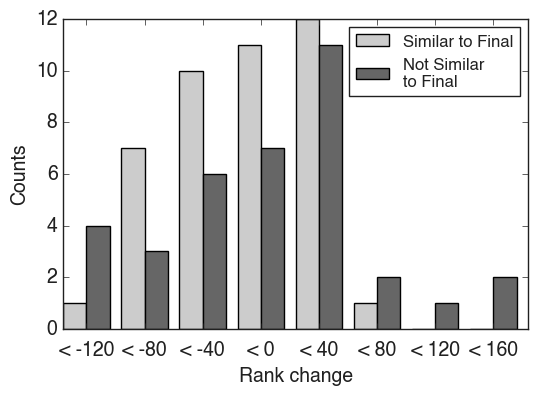

In [176]:
N = 5*2-1
bins = 40
width = 0.4
ind = [(-i) for i in sorted(range(5), reverse=True)]
ind.extend([i for i in range(5) if i > 0])
ind = np.array(ind)

i = 0
similar_to_final = np.zeros(N); not_similar_to_final = np.zeros(N)
for delta_rank in sorted(final_vs_delta_rank.keys()):
    if delta_rank >= bins*((i-4) + 1):
        i += 1
    #print(delta_rank, bins*((i-4) + 1), final_vs_delta_rank[delta_rank])
    for x in final_vs_delta_rank[delta_rank]:
        if x:
            similar_to_final[i] += 1
        else:
            not_similar_to_final[i] += 1
    #print(similar_to_final)

fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
rects1 = ax.bar(ind[:(len(ind)-1)], similar_to_final[:(len(ind)-1)], width, color=LIGHT_COLOR_V)
rects2 = ax.bar(ind[:(len(ind)-1)] + width, not_similar_to_final[:(len(ind)-1)], width, color=DARK_COLOR_V)
ax.legend((rects1[0], rects2[0]), ('Similar to Final', 'Not Similar \nto Final'), fontsize=LABEL_SIZE-2)
ax.set_xticks(ind[:(len(ind)-1)] + width)
#ax.set_xticklabels(('-160', '-120', '-80', '-40', '0', '40', '80', '120', '160'))
ax.set_xticklabels(('< -120', '< -80', '< -40', '< 0', '< 40', '< 80', '< 120', '< 160'), fontsize=LABEL_SIZE)
ax.set_yticklabels(('0', '2', '4', '6', '8', '10', '12', '14'), fontsize=LABEL_SIZE)
ax.set_ylim(0, 12)
ax.set_ylabel("Counts", fontsize=LABEL_SIZE)
ax.set_xlabel("Rank change", fontsize=LABEL_SIZE)
plt.show()

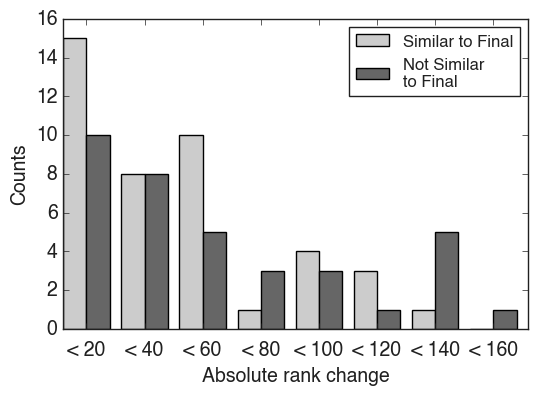

In [177]:
N = 8
bins = 20
width = 0.4
ind = np.array(range(N))
i = 0

abs_ranks = sorted(np.unique([abs(key) for key in final_vs_delta_rank.keys()]))
similar_to_final = np.zeros(N); not_similar_to_final = np.zeros(N)
for delta_rank in abs_ranks:
    if delta_rank >= bins*(i + 1):
        i += 1
    
    for x in final_vs_delta_rank[delta_rank]:
        if x:
            similar_to_final[i] += 1
        else:
            not_similar_to_final[i] += 1
    for x in final_vs_delta_rank[-(delta_rank)]:
        if x:
            similar_to_final[i] += 1
        else:
            not_similar_to_final[i] += 1
    
fig, ax = plt.subplots(1, 1, figsize=SINGLE_FIG_SIZE)
rects1 = ax.bar(ind, similar_to_final, width, color=LIGHT_COLOR_V)
rects2 = ax.bar(ind + width, not_similar_to_final, width, color=DARK_COLOR_V)
ax.legend((rects1[0], rects2[0]), ('Similar to Final', 'Not Similar \nto Final'), fontsize=LABEL_SIZE-2)
ax.set_xticks(ind + width)
ax.set_xticklabels(('< 20', '< 40', '< 60', '< 80', '< 100', '< 120', '< 140', '< 160'), fontsize=LABEL_SIZE)
ax.set_yticklabels(('0', '2', '4', '6', '8', '10', '12', '14', '16'), fontsize=LABEL_SIZE)
ax.set_ylabel("Counts", fontsize=LABEL_SIZE)
ax.set_xlabel("Absolute rank change", fontsize=LABEL_SIZE)
plt.show()

In [174]:
"How many people moved up? {0} How many moved down? {1}".format(num_people_moved_up, num_people_moved_down)

'How many people moved up? 49 How many moved down? 29'

In [175]:
(final_moved_up/num_people_moved_up, final_moved_down/num_people_moved_down)

(0.5918367346938775, 0.4482758620689655)

In [16]:
#fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
#plt.hist(diffs_mu)
#plt.show()

In [17]:
#fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
#plt.hist(diffs_sigma, bins=100)
#plt.show()

In [6]:
#fig, ax = plt.subplots(1,1, figsize=SINGLE_FIG_SIZE)
#plt.hist(personal_pub_rates, bins=100)
#plt.show()